In [1]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
import pandas as pd
import os
from itertools import product
from argparse import Namespace
from option_hedging import compute_objective
from table_utils import *

In [2]:
def expected_shortfall(vals, q):
    quantile = np.quantile(vals, q, axis=-1)
    return np.array([np.mean(vals[i, vals[i,:] <= quantile[i]]) for i in range(quantile.size)])

# Varying risk parameters

In [3]:
gradient_types_str = {"complete": "Complete policy gradient", "naive": "Naive policy gradient", "ppo": "PPO"}
objectives_str = {"cost": "Cost", "forsyth": "2nd moment", "exponential": "Exponential"}
objectives_list = list(objectives_str.keys())
objectives_names = {"lambda": "Exponential", "gamma": "2nd moment"}
param_keys = ("gamma", "lambda")
method_keys = ("complete", "naive")

directory_str = "results/hedging/"
directory = os.fsencode(directory_str)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".pkl") and filename.startswith("baseline"):
        result = pickle.load( open( directory_str + filename, "rb" ) )
        args = Namespace(**result)
        baseline_endvals = result["endvals"]
        baseline_results = result
        
directories_str = {k: directory_str + "hedging_{}/".format(k) for k in param_keys}
vals = {k1: {k2: [] for k2 in method_keys} for k1 in param_keys}
baseline_vals = {k1: {k2: [] for k2 in method_keys} for k1 in param_keys}
param_vals = {k1: {k2: [] for k2 in method_keys} for k1 in param_keys}
results = {k1: {k2: [] for k2 in method_keys} for k1 in param_keys}

for key in param_keys: 
    directory = os.fsencode(directories_str[key])
    i = 0
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".pkl"):
            result = pickle.load( open( directories_str[key] + filename, "rb" ) )
            args = Namespace(**result)
            vals[key][args.gradient_type].append(torch.mean(compute_objective(result["endvals"], args), axis=-1).detach().numpy())
            baseline_vals[key][args.gradient_type].append(torch.mean(compute_objective(baseline_endvals, args), axis=-1).detach().numpy())
            param_vals[key][args.gradient_type].append(args.gamma if key == "gamma" else args.exp_param)
            results[key][args.gradient_type].append(result)
            i += 1
            print(i)
            
param_order = {k1: {k2: [] for k2 in ("complete", "naive")} for k1 in param_keys}
for k1 in param_keys:
    for k2 in ("complete", "naive"):
        param_vals[k1][k2] = np.array(param_vals[k1][k2])
        param_order[k1][k2] = np.argsort(param_vals[k1][k2])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


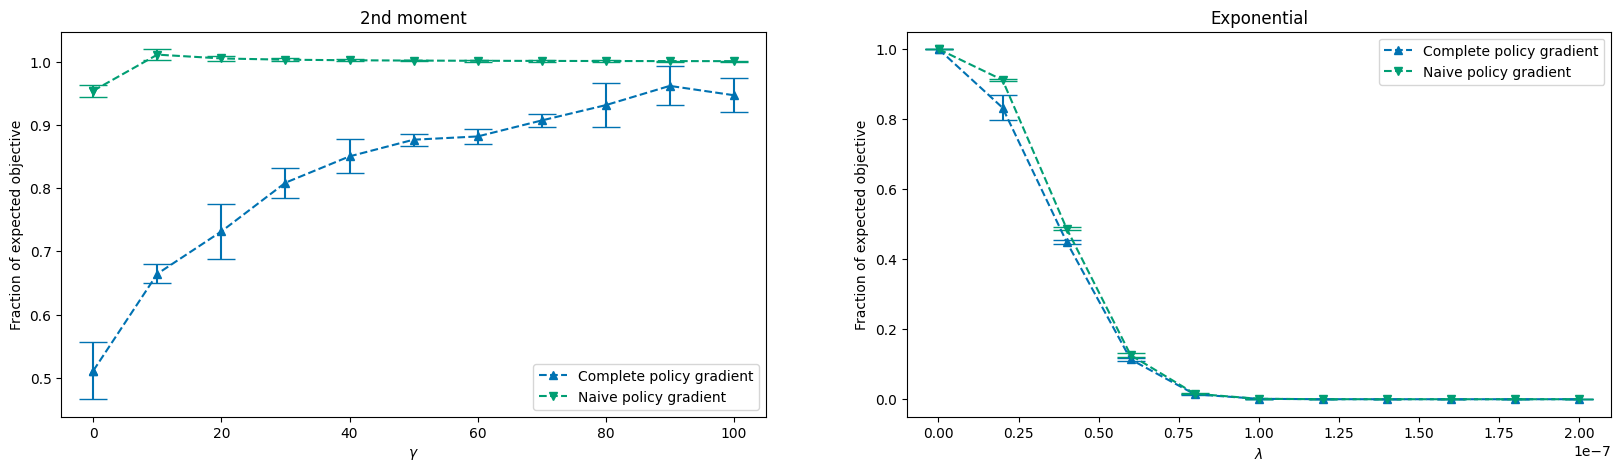

In [4]:
plt.style.use('seaborn-colorblind')
markers = ("^--", "v--", "o--", "s--")
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(1, 2, figsize=(20,5))

for i in range(2):
    k1 = param_keys[i]
    ax = axs[i] 
    col_idx = 0
    for j in range(2):
        k2 = method_keys[j]
        name = gradient_types_str[k2]
        ys =  np.stack(vals[k1][k2], axis=-1)/np.stack(baseline_vals[k1][k2], axis=-1) #- np.stack(vals[k1][k2], axis=-1)
        xs = param_vals[k1][k2][param_order[k1][k2]]
        std_values = np.std(ys, axis=0)
        mean_values = np.mean(ys, axis=0)
        ax.errorbar(xs, mean_values[param_order[k1][k2]], yerr=std_values[param_order[k1][k2]], capsize=10, fmt=markers[col_idx], markersize=6)
        ax.plot((xs[0],),(mean_values[param_order[k1][k2][0]],), markers[col_idx], label=name, color=cols[col_idx], markersize=6)
        col_idx += 1

    ax.legend()
    ax.set_title(objectives_names[k1])
    ax.set_xlabel("$\{}$".format(k1))
    ax.set_ylabel("Fraction of expected objective")


tikzplotlib.save('results/hedging_risk_aversion_diff.tex', figure=fig, encoding='utf-8')
#plt.savefig('results/hedging_risk_aversion_diff.png')
plt.show()

# Comparing methods

In [5]:
results = []
filenames = []
directory = os.fsencode(directory_str)
gradient_types = {"complete": "Complete policy gradient", "naive": "Naive policy gradient", "ppo": "PPO"}
objectives = {"cost": "Cost", "forsyth_high": "2nd moment, high risk aversion", "forsyth_low": "2nd moment, low risk aversion", "exponential_high": "Exponential, high risk aversion", "exponential_low": "Exponential, low risk aversion"}
objectives_list = list(objectives.keys())
objective_types = ("cost", "forsyth", "exponential")
param_values = (None, 0, 50, 2e-7, 2e-8, 0.01)
baselines_str = {"delta": "Delta hedging", "no_trading": "No hedging"}
    
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".pkl"):
        filenames.append(filename)
        results.append(pickle.load( open( directory_str + filename, "rb" ) ))
        
num_runs = results[0]["num_runs"] 
columns = ["objective"] + list(baselines_str.values())
for e1,e2 in product(objectives.values(), gradient_types.values()):
    columns.append(e1+": "+e2)
    
objectives_list.append('es')
objectives["es"] = "Expected shortfall"
df_hedging = pd.DataFrame(columns=columns, index=np.arange(num_runs * len(objectives_list)), dtype="float")
for i in range(len(objectives)):
    df_hedging.loc[i*num_runs:(i+1)*num_runs-1, "objective"] = objectives[objectives_list[i]]
    
names = []
torch_cols = []
for i in range(len(results)):
    r = results[i]
    args = Namespace(**r)
    using_torch = True
    if "objective" in r:
        if r["objective"] == "forsyth":
            objective_name = "forsyth_low" if args.gamma == 50 else "forsyth_high"
        elif r["objective"] == "exponential":
            objective_name = "exponential_low" if args.exp_param == 2e-8 else "exponential_high"
        else:
            objective_name = r["objective"]
    if filenames[i].startswith("option_hedging"):
        c = objectives[objective_name] + ": " + gradient_types[r["gradient_type"]] 
    elif filenames[i].startswith("ppo_option_hedging"):
        c = objectives[objective_name] + ": " + gradient_types["ppo"] 
        using_torch = False
    else:
        idx = filenames[i].find("option_hedging") - 1
        c = baselines_str["no_trading" if filenames[i][:idx] == "baseline" else filenames[i][:idx]]
    names.append(c)
    for j in range(len(objectives)):
        args.objective = objectives_list[j].split("_")[0]
        if args.objective == "forsyth":
            args.gamma = param_values[j]
        elif args.objective == "exponential":
            args.exp_param = param_values[j]
        if objectives_list[j] == "es":
            if using_torch:
                vals = r["endvals"].detach().numpy()
            else:
                vals = r["endvals"]
            df_hedging.loc[j*num_runs:(j+1)*num_runs-1, c] = expected_shortfall(vals, param_values[j])
        elif using_torch:
            vals = torch.mean(compute_objective(r["endvals"], args), axis=-1)
            df_hedging.loc[j*num_runs:(j+1)*num_runs-1, c] = vals.detach().numpy()
        else:
            vals = np.mean(compute_objective(r["endvals"], args, using_torch=False), axis=-1)
            df_hedging.loc[j*num_runs:(j+1)*num_runs-1, c] = vals
    torch_cols.append(using_torch)
    
grouped_hedging, code_hedging = make_transposed_table(df_hedging,
                     ["objective"],
                     [c for c in columns if c != "objective"],
                     num_decimal = 4
                          )

table_filename = f"results/hedging.tex"
with open(table_filename, "w") as fp:
    fp.write(code_hedging)

In [6]:
grouped_hedging

objective                                                    Cost  \
Delta hedging                                      mean  3.169941   
                                                   std   0.002755   
No hedging                                         mean  2.816512   
                                                   std   0.004902   
Cost: Complete policy gradient                     mean  0.805820   
                                                   std   0.364867   
Cost: Naive policy gradient                        mean  2.832425   
                                                   std   0.011758   
Cost: PPO                                          mean  2.818561   
                                                   std   0.001657   
2nd moment, high risk aversion: Complete policy... mean  1.625403   
                                                   std   0.241118   
2nd moment, high risk aversion: Naive policy gr... mean  3.052891   
                                                   std   0.007856   
2nd moment, high risk aversion: PPO                mean  2.818193   
                                                   std   0.001808   
2nd moment, low risk aversion: Complete policy ... mean  0.974510   
                                                   std   0.183800   
2nd moment, low risk aversion: Naive policy gra... mean  2.829353   
                                                   std   0.021524   
2nd moment, low risk aversion: PPO                 mean  2.818193   
                                                   std   0.001808   
Exponential, high risk aversion: Complete polic... mean  3.032655   
                                                   std   0.008090   
Exponential, high risk aversion: Naive policy g... mean  3.136318   
                                                   std   0.010430   
Exponential, high risk aversion: PPO               mean  2.815969   
                                                   std   0.003589   
Exponential, low risk aversion: Complete policy... mean  2.534775   
                                                   std   0.065149   
Exponential, low risk aversion: Naive policy gr... mean  3.046392   
                                                   std   0.009809   
Exponential, low risk aversion: PPO                mean  2.818193   
                                                   std   0.001808   

objective                                                2nd moment, high risk aversion  \
Delta hedging                                      mean                       10.771945   
                                                   std                         0.018410   
No hedging                                         mean                        9.990769   
                                                   std                         0.040862   
Cost: Complete policy gradient                     mean                        7.118974   
                                                   std                         1.077106   
Cost: Naive policy gradient                        mean                       10.302043   
                                                   std                         0.562640   
Cost: PPO                                          mean                       10.008114   
                                                   std                         0.010308   
2nd moment, high risk aversion: Complete policy... mean                        5.108508   
                                                   std                         0.500130   
2nd moment, high risk aversion: Naive policy gr... mean                        9.530357   
                                                   std                         0.089988   
2nd moment, high risk aversion: PPO                mean                       10.003370   
                                                   std                         0.004358   
2nd moment, low risk aversion: Comple

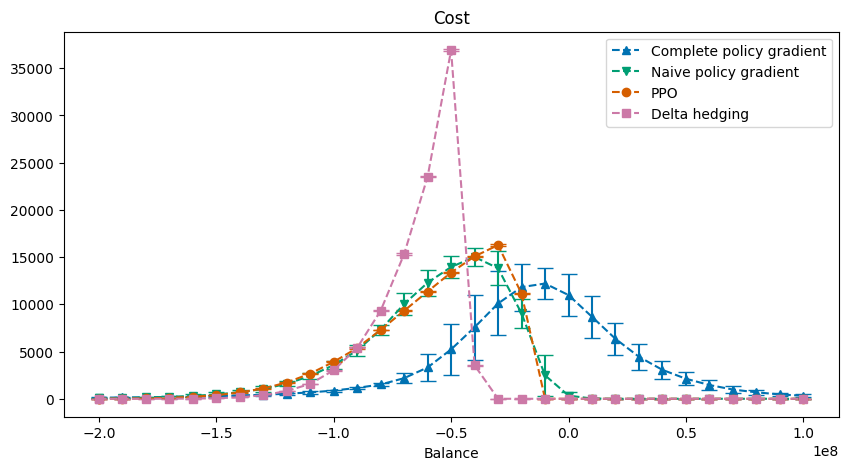

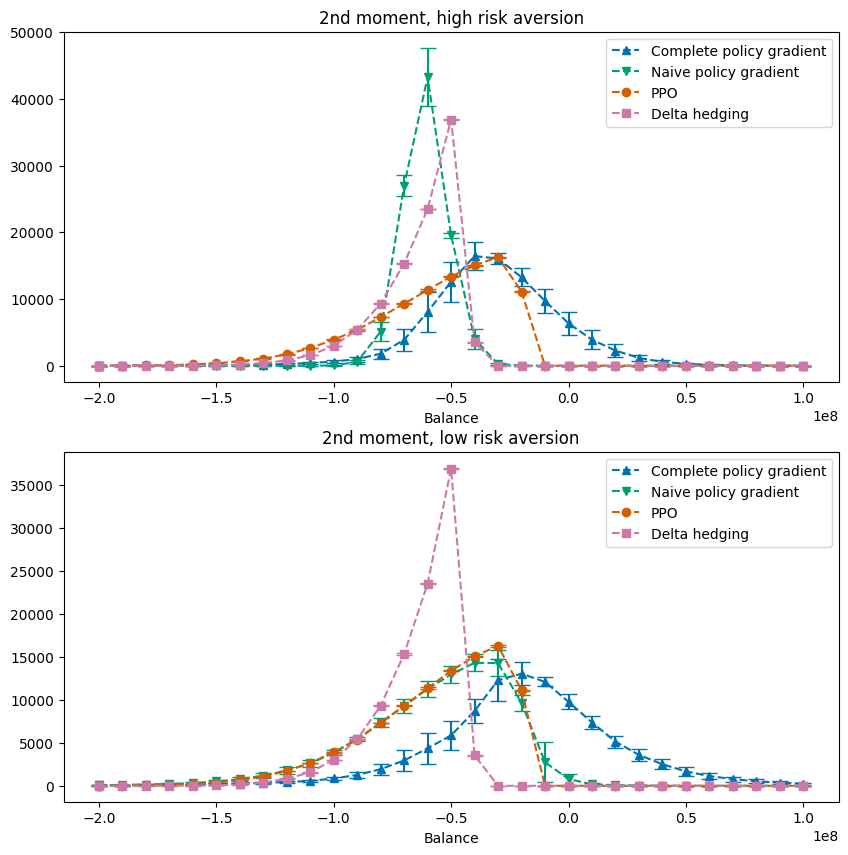

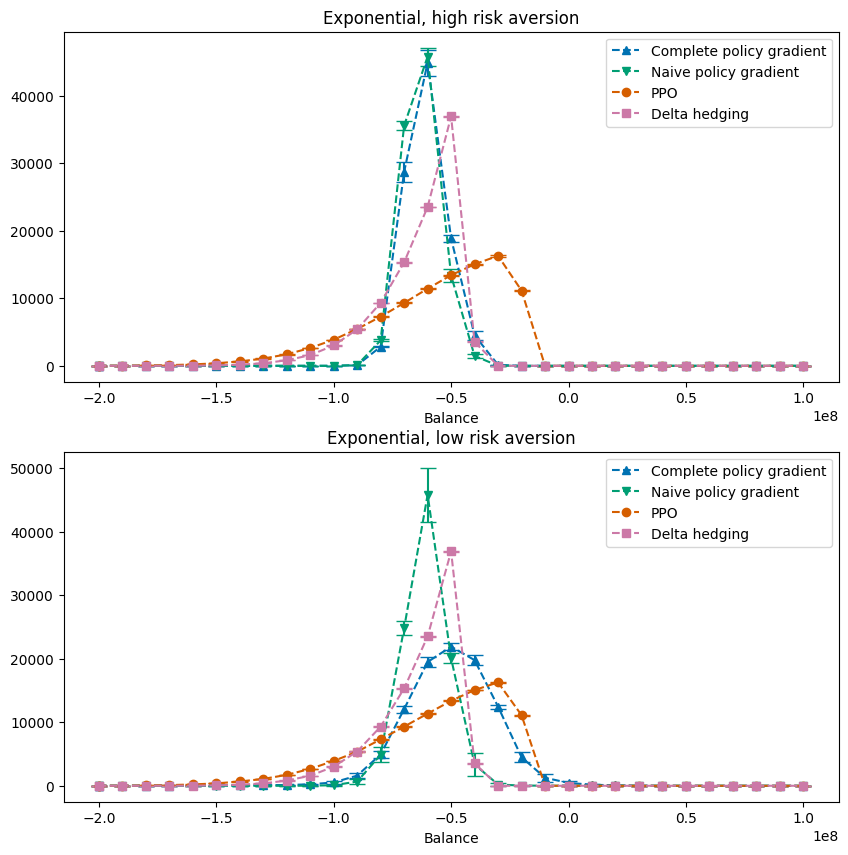

In [7]:
plt.style.use('seaborn-colorblind')
markers = ("^--", "v--", "o--", "s--", "*--")
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
param_vals = (1,2,2)
figs = [plt.subplots(i, 1, figsize=(10,5*i)) for i in param_vals]
axs = [f[1] for f in figs]
bins = (np.arange(-21, 11) + 0.5)*1e7
xs = (bins[1:] + bins[:-1])/2

for fig_i in range(len(figs)):
    obj_list = [s for s in objectives_list if s.startswith(objective_types[fig_i])]
    for ii in range(param_vals[fig_i]):
        ax = axs[fig_i] if param_vals[fig_i] == 1 else axs[fig_i][ii] 
        col_idx = 0
        for j in range(len(results)):
            r = results[j]
            if "objective" in r:
                if r["objective"] == "forsyth":
                    objective_name = "forsyth_low" if r["gamma"] == 50 else "forsyth_high"
                elif r["objective"] == "exponential":
                    objective_name = "exponential_low" if r["exp_param"] == 2e-8 else "exponential_high"
                else:
                    objective_name = r["objective"]
            if "objective" in r.keys() and r["objective"] == objective_types[fig_i]:
                idx = obj_list.index(objective_name)
                if idx == ii:
                    name = names[j].split("_")[0].replace("ppo", "PPO").split(": ")[-1]
                    if torch_cols[j]:
                        endvals = r["endvals"].detach().numpy()
                    else:
                        endvals = r["endvals"]
                    freqs = np.stack([np.histogram(endvals[n,:], bins=bins, density=False)[0] for n in range(num_runs)])  
                    std_values = np.std(freqs, axis=0)
                    mean_values = np.mean(freqs, axis=0)
                    ax.errorbar(xs, mean_values, yerr=std_values, capsize=6, fmt=markers[col_idx], markersize=6)
                    ax.plot(xs[0], mean_values[0], markers[col_idx], label=name, color=cols[col_idx], markersize=6)
                    col_idx += 1

        for j in range(len(results)):
            if names[j] == "Delta hedging":
                r = results[j]
                freqs = np.stack([np.histogram(r["endvals"][n,:], bins=bins, density=False)[0] for n in range(num_runs)])  
                std_values = np.std(freqs, axis=0)
                mean_values = np.mean(freqs, axis=0)
                ax.errorbar(xs, mean_values, yerr=std_values, capsize=6, color=cols[col_idx], fmt=markers[col_idx], markersize=6)
                ax.plot(xs[0], mean_values[0], markers[col_idx], label=names[j], color=cols[col_idx], markersize=6)
                col_idx += 1
        ax.set_xlabel("Balance")
        ax.legend()
        ax.set_title(objectives[obj_list[ii]])

    tikzplotlib.save('results/hedging_histogram_{}.tex'.format(objective_types[fig_i]), figure=figs[fig_i][0], encoding='utf-8')
plt.show()

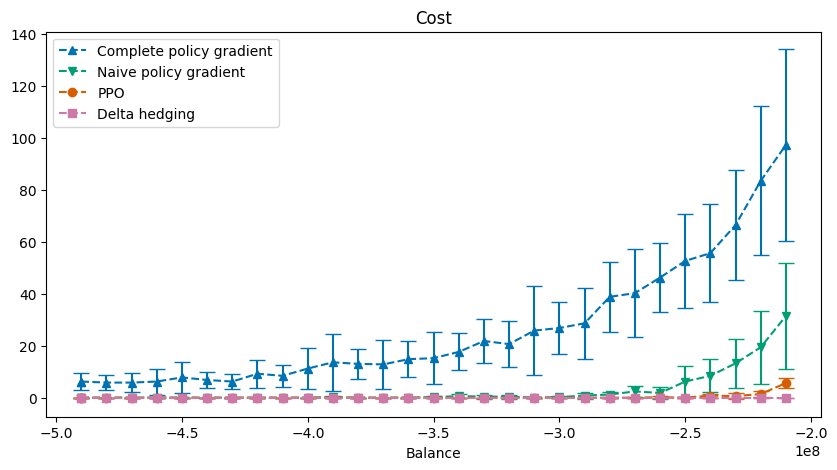

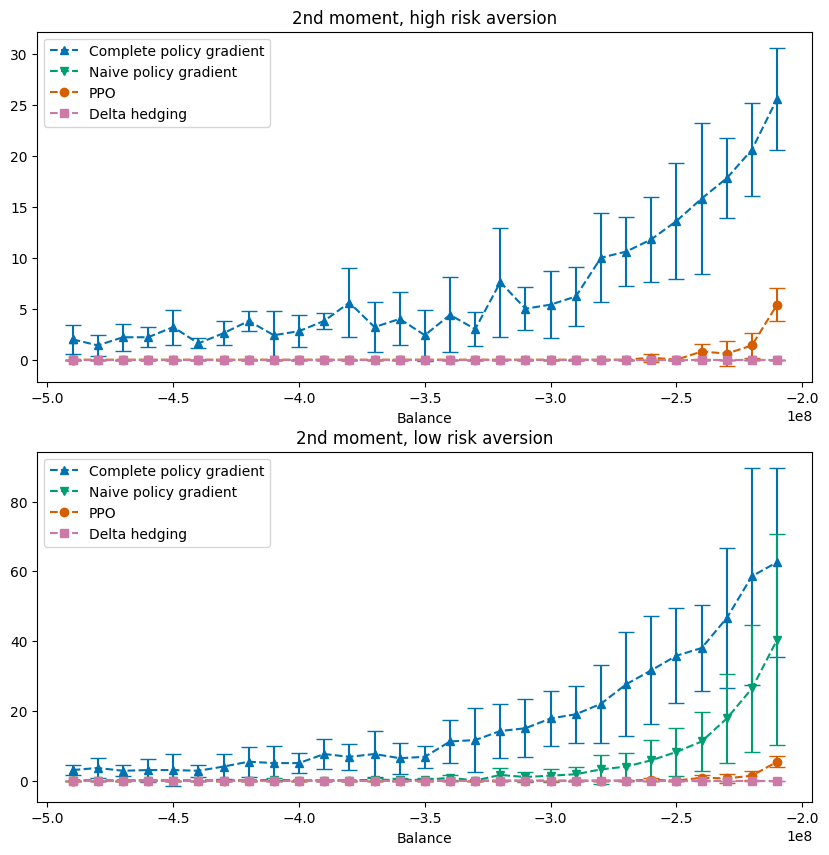

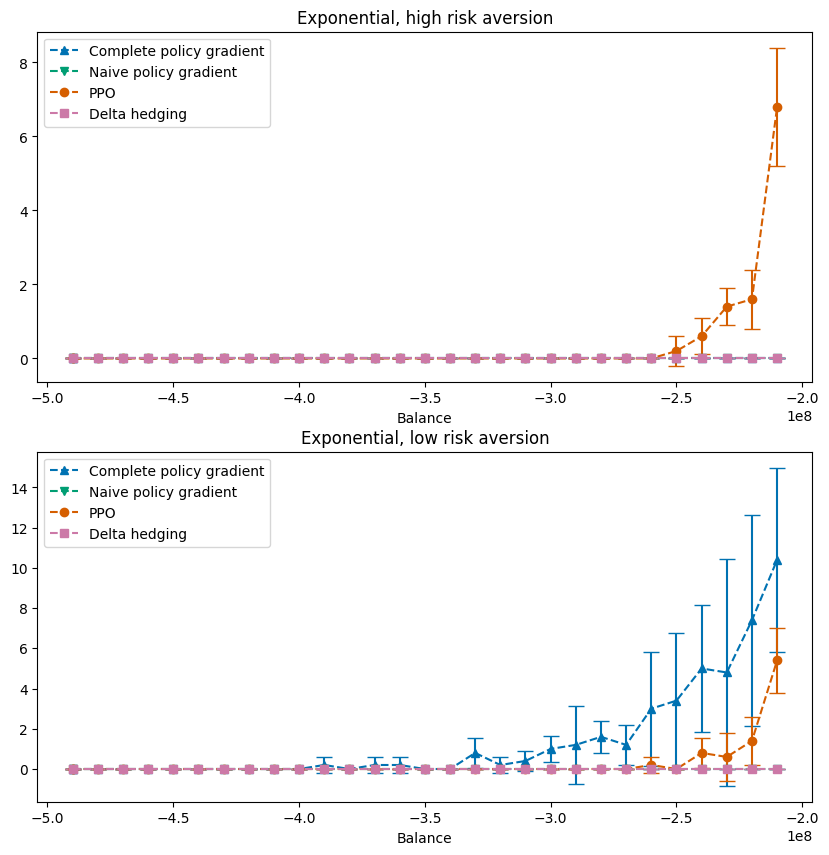

In [8]:
plt.style.use('seaborn-colorblind')
markers = ("^--", "v--", "o--", "s--", "*--")
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
param_vals = (1,2,2)
figs = [plt.subplots(i, 1, figsize=(10,5*i)) for i in param_vals]
axs = [f[1] for f in figs]
bins = (np.arange(-50, -20) + 0.5)*1e7
xs = (bins[1:] + bins[:-1])/2

for fig_i in range(len(figs)):
    obj_list = [s for s in objectives_list if s.startswith(objective_types[fig_i])]
    for ii in range(param_vals[fig_i]):
        ax = axs[fig_i] if param_vals[fig_i] == 1 else axs[fig_i][ii] 
        col_idx = 0
        for j in range(len(results)):
            r = results[j]
            if "objective" in r:
                if r["objective"] == "forsyth":
                    objective_name = "forsyth_low" if r["gamma"] == 50 else "forsyth_high"
                elif r["objective"] == "exponential":
                    objective_name = "exponential_low" if r["exp_param"] == 2e-8 else "exponential_high"
                else:
                    objective_name = r["objective"]
            if "objective" in r.keys() and r["objective"] == objective_types[fig_i]:
                idx = obj_list.index(objective_name)
                if idx == ii:
                    name = names[j].split("_")[0].replace("ppo", "PPO").split(": ")[-1]
                    if torch_cols[j]:
                        endvals = r["endvals"].detach().numpy()
                    else:
                        endvals = r["endvals"]
                    freqs = np.stack([np.histogram(endvals[n,:], bins=bins, density=False)[0] for n in range(num_runs)])  
                    std_values = np.std(freqs, axis=0)
                    mean_values = np.mean(freqs, axis=0)
                    ax.errorbar(xs, mean_values, yerr=std_values, capsize=6, fmt=markers[col_idx], markersize=6)
                    ax.plot(xs[0], mean_values[0], markers[col_idx], label=name, color=cols[col_idx], markersize=6)
                    col_idx += 1

        for j in range(len(results)):
            if names[j] == "Delta hedging":
                r = results[j]
                freqs = np.stack([np.histogram(r["endvals"][n,:], bins=bins, density=False)[0] for n in range(num_runs)])  
                std_values = np.std(freqs, axis=0)
                mean_values = np.mean(freqs, axis=0)
                ax.errorbar(xs, mean_values, yerr=std_values, capsize=6, color=cols[col_idx], fmt=markers[col_idx], markersize=6)
                ax.plot(xs[0], mean_values[0], markers[col_idx], label=names[j], color=cols[col_idx], markersize=6)
                col_idx += 1
        ax.set_xlabel("Balance")
        ax.legend()
        ax.set_title(objectives[obj_list[ii]])

    tikzplotlib.save('results/hedging_histogram_tail_{}.tex'.format(objective_types[fig_i]), figure=figs[fig_i][0], encoding='utf-8')
plt.show()